## Simple EDA to understand the dataset
- whats in our dataset
- what do they look like

In [1]:
import pandas as pd
import numpy as np
import keras

Using TensorFlow backend.
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lynette/opt/anaconda3/lib/pytho

In [2]:
%%time
train = pd.read_csv('../data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
# note: this process took 2min 10scs on my computer

CPU times: user 1min 8s, sys: 14 s, total: 1min 22s
Wall time: 1min 16s


In [3]:
train_df = train

In [2]:
train_df.head()

NameError: name 'train_df' is not defined

In [16]:
train_df.shape

(629145480, 2)

## Calculate aggregated features

## LSTM Using Keras

In [4]:
chunk_size = 150000

chunks = int(np.floor(train_df.shape[0]/chunk_size))

X_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['min','max','std', 'avg', 'sum', 'median', 'mean_diff', 
                                                                       'q05', 'q25', 'q75', 'q95'])
y_data = pd.DataFrame(index=range(chunks), dtype=np.float32, columns=['ttf'])

def create_features(data_chunk, X_df, chunk_no, col_name='acoustic_data'):
    x = data_chunk[col_name]
    X_df.loc[chunk_no, 'min'] = x.min()
    X_df.loc[chunk_no, 'max'] = x.max()
    X_df.loc[chunk_no, 'std'] = x.std()
    X_df.loc[chunk_no, 'avg'] = x.mean()
    X_df.loc[chunk_no, 'sum'] = x.sum()
    X_df.loc[chunk_no, 'median'] = x.median()
    X_df.loc[chunk_no, 'mean_diff'] = np.mean(np.diff(x))
    X_df.loc[chunk_no, 'q05'] = np.quantile(x, 0.05)
    X_df.loc[chunk_no, 'q25'] = np.quantile(x, 0.25)
    X_df.loc[chunk_no, 'q75'] = np.quantile(x, 0.75)
    X_df.loc[chunk_no, 'q95'] = np.quantile(x, 0.95)
    return X_df

In [5]:
from tqdm import tqdm
for chunk_no in tqdm(range(chunks)):
    data_chunk = train_df.iloc[chunk_no*chunk_size:chunk_no*chunk_size+chunk_size]
    X_data = create_features(data_chunk, X_data, chunk_no)
    y = data_chunk['time_to_failure'].values[-1]
    y_data.loc[chunk_no, 'ttf'] = y

100%|██████████| 4194/4194 [00:40<00:00, 102.82it/s]


In [6]:
print(X_data.shape)
print(y_data.shape)
print(X_data.shape[1])
X_data.head()

(4194, 11)
(4194, 1)
11


,min,max,std,avg,sum,median,mean_diff,q05,q25,q75,q95
0,-98.0,104.0,5.101106,4.884113,732617.0,5.0,-0.000080,-2.0,3.0,7.0,11.0
1,-154.0,181.0,6.588824,4.725767,708865.0,5.0,0.000000,-2.0,2.0,7.0,12.0
2,-106.0,140.0,6.967397,4.906394,735959.0,5.0,-0.000013,-3.0,2.0,7.0,13.0
3,-199.0,197.0,6.922305,4.902240,735336.0,5.0,0.000000,-2.0,2.0,7.0,12.0
4,-126.0,145.0,7.301110,4.908720,736308.0,5.0,-0.000007,-2.0,2.0,7.0,12.0


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data.values, y_data.values, test_size=0.2)
# X_test
# X_data.values
X_train.shape

(3355, 11)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(LSTM(512, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1), return_sequences = True))
#model.add(CuDNNGRU(64, kernel_initializer="RandomUniform", input_shape= (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(1))


Instructions for updating:
Colocations handled automatically by placer.


In [9]:

# Reshaping for fit
# X_train_array = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train_array = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train_array = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

print(X_train_array.shape)
print(y_train_array.shape)

(3355, 11, 1)
(3355, 1, 1)


In [10]:



# model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics=["mse"])
opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_absolute_error", optimizer=opt, metrics=["mae", "mse"])
#model.summary()

build = model.fit(X_train_array, y_train, epochs=150, batch_size=30, validation_split = 0.20, verbose=1, shuffle = False)

Instructions for updating:
Use tf.cast instead.
Train on 2684 samples, validate on 671 samples
Epoch 1/150
2684/2684 [==============================] - 10s 4ms/step - loss: 5.4300 - mae: 5.4300 - mse: 43.1215 - val_loss: 4.8305 - val_mae: 4.8305 - val_mse: 36.2690
Epoch 2/150
2684/2684 [==============================] - 9s 3ms/step - loss: 4.5603 - mae: 4.5603 - mse: 33.1497 - val_loss: 3.7803 - val_mae: 3.7803 - val_mse: 23.6355
Epoch 3/150
2684/2684 [==============================] - 9s 3ms/step - loss: 3.6699 - mae: 3.6699 - mse: 22.2283 - val_loss: 3.1575 - val_mae: 3.1575 - val_mse: 15.1454
Epoch 4/150
2684/2684 [==============================] - 8s 3ms/step - loss: 3.2384 - mae: 3.2384 - mse: 16.7403 - val_loss: 3.0785 - val_mae: 3.0785 - val_mse: 13.5055
Epoch 5/150
2684/2684 [==============================] - 9s 3ms/step - loss: 3.2210 - mae: 3.2210 - mse: 15.7530 - val_loss: 3.0788 - val_mae: 3.0788 - val_mse: 13.4289
Epoch 6/150
2684/2684 [==============================] - 9s

2684/2684 [==============================] - 9s 3ms/step - loss: 2.3593 - mae: 2.3593 - mse: 9.6319 - val_loss: 2.1177 - val_mae: 2.1177 - val_mse: 7.4131
Epoch 96/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.3566 - mae: 2.3566 - mse: 9.8063 - val_loss: 2.1156 - val_mae: 2.1156 - val_mse: 7.3943
Epoch 97/150
2684/2684 [==============================] - 11s 4ms/step - loss: 2.3657 - mae: 2.3657 - mse: 9.6464 - val_loss: 2.0985 - val_mae: 2.0985 - val_mse: 7.3473
Epoch 98/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.3273 - mae: 2.3273 - mse: 9.5173 - val_loss: 2.1773 - val_mae: 2.1773 - val_mse: 7.5562
Epoch 99/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.3581 - mae: 2.3581 - mse: 9.6584 - val_loss: 2.1151 - val_mae: 2.1151 - val_mse: 7.3580
Epoch 100/150
2684/2684 [==============================] - 9s 3ms/step - loss: 2.3302 - mae: 2.3302 - mse: 9.4605 - val_loss: 2.1752 - val_mae: 2.1752 - val_mse: 7.5686
Epo

dict_keys(['val_loss', 'val_mae', 'val_mse', 'loss', 'mae', 'mse'])


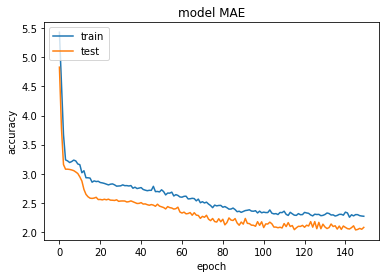

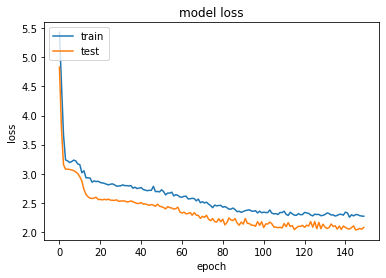

In [12]:
import matplotlib.pyplot as plt
# list all data in history
print(build.history.keys())
# summarize history for accuracy
plt.plot(build.history['mae'])
plt.plot(build.history['val_mae'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(build.history['loss'])
plt.plot(build.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
model.save("model-single-direction.h5")
print("Saved model to disk")

Saved model to disk


## save test result

In [14]:
submission = pd.read_csv("../data/sample_submission.csv", index_col='seg_id', dtype={"time_to_failure": np.float32})
X_sub = pd.DataFrame(columns=X_data.columns, dtype=np.float32)

for i, seg_id in enumerate(tqdm(submission.index)):
    seg = pd.read_csv('../data/test/' + str(seg_id) + '.csv')
    X_seg = create_features(seg, X_sub, i)

100%|██████████| 2624/2624 [00:52<00:00, 49.60it/s]


In [15]:
X_seg_array = np.reshape(X_seg.values, (X_seg.shape[0], X_seg.shape[1], 1))
pred_final = model.predict(X_seg_array)
submission['time_to_failure'] = pred_final

submission.to_csv('submission-LSTM-single-direction.csv')

## plot the test acoustic data

            time_to_failure
seg_id                     
seg_004314         0.759541
seg_0e3d44         0.940253
seg_26a2a0         0.564851
seg_2f86cd         0.614960
seg_39ad50         0.772291
seg_3b2013         0.944508
seg_3e87b4         0.756773
seg_4e3bd7         0.993802
seg_5c57a8         0.927430
seg_724df9         0.565960
seg_7848f8         0.596353
seg_7a9f2b         0.574037
seg_7fa6ec         0.565151
seg_87e4e8         0.911540
seg_8be76c         0.894658
seg_8dfd7a         0.981838
seg_90b174         0.839806
seg_a1a511         0.981463
seg_aa98cc         0.579625
seg_b35174         0.562655
seg_b686e5         0.746278
seg_bfdd14         0.759013
seg_c243a6         0.982176
seg_c5dee4         0.910852
seg_c80857         0.572809
seg_c9831a         0.880872
seg_e3d751         0.540060
seg_fdd50e         0.843872
<class 'pandas.core.frame.DataFrame'>
Index(['time_to_failure'], dtype='object')
seg_26a2a0


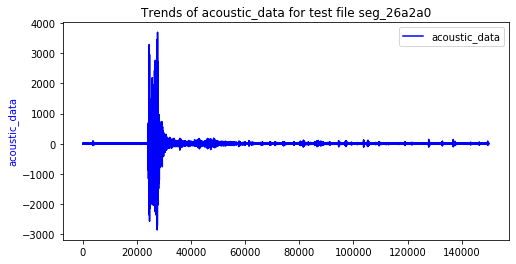

In [16]:
possible_eq = submission.loc[submission["time_to_failure"] < 1.0]
print(possible_eq)
print(type(possible_eq))
print(possible_eq.columns)
segments = ["seg_26a2a0"]
for seg_id in segments:
    print(seg_id)
    seg = pd.read_csv('../data/test/' + seg_id + '.csv')
    fig, ax1 = plt.subplots(figsize=(8, 4))
    plt.title("Trends of acoustic_data for test file {}".format(seg_id))
    plt.plot(seg['acoustic_data'].values, color='b')
    ax1.set_ylabel('acoustic_data', color='b')
    plt.legend(['acoustic_data'])

In [1]:
from keras.models import load_model
 
# load model
model = load_model('model-single-direction.h5')




Using TensorFlow backend.
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lynette/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lynette/opt/anaconda3/lib/pytho

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


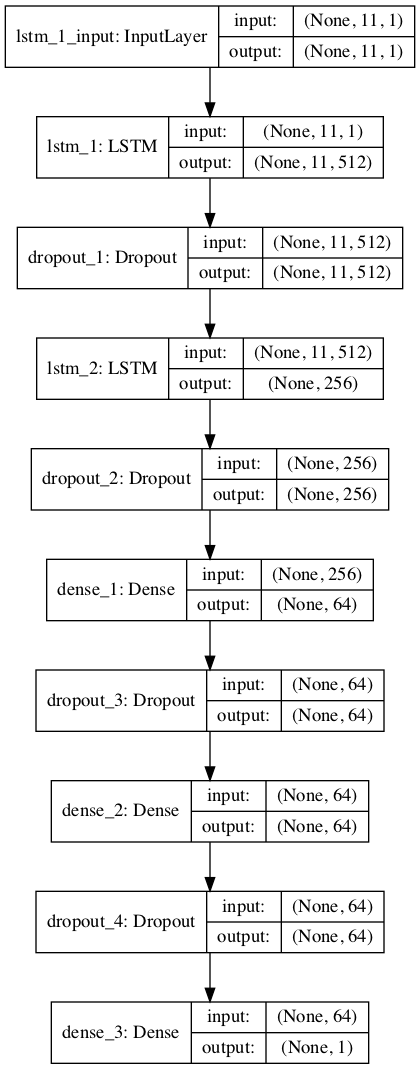

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [3]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.
